## Import

In [31]:
import random
import pandas as pd
import numpy as np
import os
from PIL import Image
import torch
import cv2 as cv
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.ttf" 
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
from torchvision.models import resnet18, resnet34
from torchvision import transforms

from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('cuda')
else:
    device = torch.device('cpu')
    print('cpu')

cuda


## Hyperparameter Setting

In [3]:
CFG = {
    'IMG_HEIGHT_SIZE':64,
    'IMG_WIDTH_SIZE':224,
    'EPOCHS': 10,
    'LEARNING_RATE':1e-3,
    'BATCH_SIZE':256,
    'NUM_WORKERS':0,
    'SEED':41
}

## Fixed RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Load & Train/Validation Split

In [5]:
df = pd.read_csv('./open/train.csv')

In [6]:
df['len']= df['label'].str.len()
df.head()

,id,img_path,label,len
0,TRAIN_00000,./train/TRAIN_00000.png,빨간색,3
1,TRAIN_00001,./train/TRAIN_00001.png,머,1
2,TRAIN_00002,./train/TRAIN_00002.png,차차,2
3,TRAIN_00003,./train/TRAIN_00003.png,써,1
4,TRAIN_00004,./train/TRAIN_00004.png,놓치다,3


In [7]:
train_len_count = pd.DataFrame(df['len'].value_counts())
train_len_count = train_len_count.reset_index()
train_len_count.columns = ['len', 'len_count']

display(train_len_count)

,len,len_count
0,2,28631
1,1,23703
2,3,13514
3,4,9988
4,5,1026
5,6,26


Text(0.5, 1.0, 'Character Count Frequency')

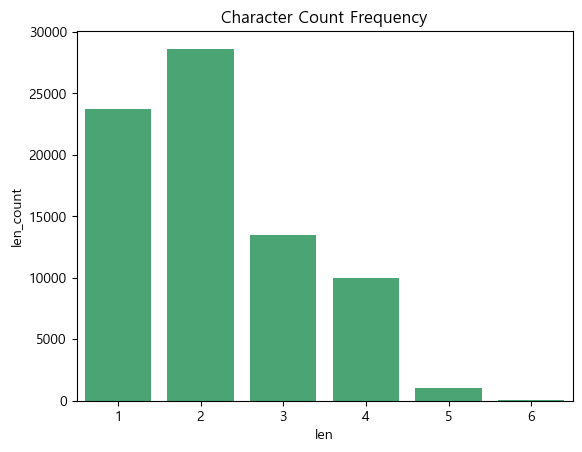

In [8]:
import seaborn as sns
color = 'mediumseagreen'
ax = sns.barplot(data=train_len_count, x='len', y='len_count', color=color)
ax.set_title('Character Count Frequency')

In [9]:
def show_image(Image, Picture_Name):
    plt.imshow(Image)
    plt.title(Picture_Name)
    plt.show()
    
def sample_df_by_len(df, n_sample, n_len, use_frac=False):
  cond = (df['len']==n_len)
  df = df.loc[cond]
  if use_frac == True:
    df = df.sample(frac=n_sample)
  else:
    df = df.sample(n=n_sample)
  return df

def show_sample_image(df, n_sample, n_len):
  df = sample_df_by_len(df, n_sample, n_len)
  i = 1
  plt.figure(figsize=(3,9))
  for img, label in zip(df['img_path'], df['label']):
    img = cv.imread(img)
    plt.subplot(1,3, i)
    show_image(img, label)
    i = i+1

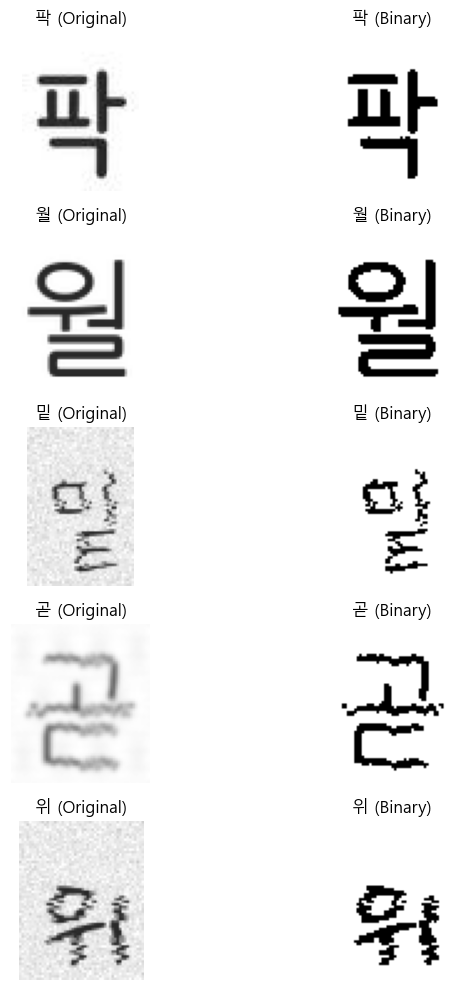

In [10]:
def show_image(image, picture_name):
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.title(picture_name)
    plt.axis('off')
    plt.show()

def sample_df_by_len(df, n_sample, n_len, use_frac=False):
    cond = (df['len'] == n_len)
    df = df.loc[cond]
    if use_frac:
        df = df.sample(frac=n_sample)
    else:
        df = df.sample(n=n_sample)
    return df

def show_sample_binary_image(df, n_sample, n_len):
    df = sample_df_by_len(df, n_sample, n_len)
    fig, axes = plt.subplots(n_sample, 2, figsize=(8, 2*n_sample))
    for i, (img_path, label) in enumerate(zip(df['img_path'], df['label'])):
        image = cv.imread(img_path)
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        _, binary_image = cv.threshold(gray_image, 190, 255, cv.THRESH_BINARY)
        axes[i, 0].imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        axes[i, 0].set_title(label + ' (Original)')
        axes[i, 0].axis('off')
        axes[i, 1].imshow(binary_image, cmap='gray')
        axes[i, 1].set_title(label + ' (Binary)')
        axes[i, 1].axis('off')
    plt.tight_layout()
    plt.show()
show_sample_binary_image(df, n_sample=5, n_len=1)

In [11]:
# 제공된 학습데이터 중 1글자 샘플들의 단어사전이
# 학습/테스트 데이터의 모든 글자를 담고 있으므로 학습 데이터로 우선 배치
df['len'] = df['label'].str.len()
train_v1 = df[df['len']==1]

In [12]:
# 제공된 학습데이터 중 2글자 이상의 샘플들에 대해서 
# 단어길이를 고려하여 Train (80%) / Validation (20%) 분할
df2 = df[df['len']>1]
train_v2, val, _, _ = train_test_split(df2, df2['len'], test_size=0.2, random_state=CFG['SEED'])

In [13]:
# 학습 데이터로 우선 배치한 1글자 샘플들과 분할된 2글자 이상의 학습 샘플을 
# concat하여 최종 학습 데이터로 사용
train = pd.concat([train_v1, train_v2]) # 최종학습데이터
#train = train.sample(n=1000, random_state=CFG['SEED']) # 데이터 수 = 1000개
val = val.sample(n=500, random_state=CFG['SEED']) # 검증 데이터 500개 임의 추출
print(len(train), len(val))

66251 500


## Get Vocabulary

In [14]:
# 학습 데이터로부터 단어 사전(Vocabulary) 구축
train_gt = [gt for gt in train['label']] # 학습 데이터에서 레이블 열을 추출하여 리스트로 저장
train_gt = "".join(train_gt)
letters = sorted(list(set(list(train_gt)))) #고유한 문자들이 ㄱㄴㄷ순서로 정렬되어 저장
print(len(letters))

2349


In [15]:
letters

['가',
 '각',
 '간',
 '갇',
 '갈',
 '갉',
 '갊',
 '감',
 '갑',
 '값',
 '갓',
 '갔',
 '강',
 '갖',
 '갗',
 '같',
 '갚',
 '갛',
 '개',
 '객',
 '갠',
 '갤',
 '갬',
 '갭',
 '갯',
 '갰',
 '갱',
 '갸',
 '갹',
 '갼',
 '걀',
 '걋',
 '걍',
 '걔',
 '걘',
 '걜',
 '거',
 '걱',
 '건',
 '걷',
 '걸',
 '걺',
 '검',
 '겁',
 '것',
 '겄',
 '겅',
 '겆',
 '겉',
 '겊',
 '겋',
 '게',
 '겐',
 '겔',
 '겜',
 '겝',
 '겟',
 '겠',
 '겡',
 '겨',
 '격',
 '겪',
 '견',
 '겯',
 '결',
 '겸',
 '겹',
 '겻',
 '겼',
 '경',
 '곁',
 '계',
 '곈',
 '곌',
 '곕',
 '곗',
 '고',
 '곡',
 '곤',
 '곧',
 '골',
 '곪',
 '곬',
 '곯',
 '곰',
 '곱',
 '곳',
 '공',
 '곶',
 '과',
 '곽',
 '관',
 '괄',
 '괆',
 '괌',
 '괍',
 '괏',
 '광',
 '괘',
 '괜',
 '괠',
 '괩',
 '괬',
 '괭',
 '괴',
 '괵',
 '괸',
 '괼',
 '굄',
 '굅',
 '굇',
 '굉',
 '교',
 '굔',
 '굘',
 '굡',
 '굣',
 '구',
 '국',
 '군',
 '굳',
 '굴',
 '굵',
 '굶',
 '굻',
 '굼',
 '굽',
 '굿',
 '궁',
 '궂',
 '궈',
 '궉',
 '권',
 '궐',
 '궜',
 '궝',
 '궤',
 '궷',
 '귀',
 '귁',
 '귄',
 '귈',
 '귐',
 '귑',
 '귓',
 '규',
 '균',
 '귤',
 '그',
 '극',
 '근',
 '귿',
 '글',
 '긁',
 '금',
 '급',
 '긋',
 '긍',
 '긔',
 '기',
 '긱',
 '긴',
 '긷',
 '길',
 '긺',
 '김',
 '깁'

In [16]:
vocabulary = ["-"] + letters  # "-" 문자를 포함한 문자 집합을 생성합니다. letters에는 학습 데이터에서 사용된 모든 고유한 문자가 포함되어 있습니다.
print(len(vocabulary))  # 생성된 문자 집합의 길이를 출력합니다.
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}  # 생성된 문자 집합을 인덱스와 매핑하여 딕셔너리 형태로 저장합니다. 여기서 k는 인덱스, v는 해당 문자를 나타냅니다.
char2idx = {v:k for k,v in idx2char.items()}  # 인덱스와 문자를 역으로 매핑하여 딕셔너리 형태로 저장합니다. 여기서 k는 인덱스, v는 해당 문자를 나타냅니다.


2350


In [17]:
train = train.sample(n=1000, random_state=CFG['SEED']) # 데이터 수 = 1000개
len(train)

1000

## CustomDataset

In [18]:
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.img_path_list)
    
    def __getitem__(self, index):
        image = cv.imread(self.img_path_list[index])
        gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        _, binary_image = cv.threshold(gray_image, 190, 255, cv.THRESH_BINARY)
        image = Image.fromarray(binary_image)

        
        
        if self.train_mode:
            image = self.train_transform(image)
        else:
            image = self.test_transform(image)
            
        if self.label_list is not None:
            text = self.label_list[index]
            return image, text
        else:
            return image
    
    # Image Augmentation
    def train_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            #transforms.Normalize(mean=(0.9101), std=(0.2440))
        ])
        return transform_ops(image)
    
    def test_transform(self, image):
        transform_ops = transforms.Compose([
            transforms.Resize((CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE'])),
            transforms.ToTensor(),
            #transforms.Normalize(mean=(0.9101), std=(0.2440))
        ])
        return transform_ops(image)

In [19]:
train_dataset = CustomDataset(train['img_path'].values, train['label'].values, True)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

val_dataset = CustomDataset(val['img_path'].values, val['label'].values, False)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=CFG['NUM_WORKERS'])

In [19]:
# def calculate_mean_std(loader):
#     mean = 0.
#     std = 0.
#     total_images_count = 0
    
#     for images, _ in loader:
#         batch_samples = images.size(0)  # 배치 크기
#         images = images.view(batch_samples, images.size(1), -1)
#         mean += images.mean(2).sum(0)
#         std += images.std(2).sum(0)
#         total_images_count += batch_samples
    
#     mean /= total_images_count
#     std /= total_images_count
#     return mean, std

# calculate_mean_std(train_loader)

In [21]:
# train_loader에서 다음 배치를 가져와서 image_batch와 text_batch에 할당합니다.
image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(), text_batch)
# 배치사이즈 , 채널수 , 높이, 너비

torch.Size([256, 1, 64, 224]) ('연구하다', '안기다', '몽', '끈', '그럼', '아버지', '수많다', '돌', '스스로', '토', '항', '닮다', '방식', '장면', '코드', '곌', '작성하다', '오히려', '경', '튈', '룔', '이념', '개나리', '수학', '엥', '부피', '음식', '띄', '바로', '이모', '평소', '전문가', '레', '보고서', '양상추', '얕', '퐝', '쩟', '이', '석', '식사', '암', '잘못하다', '달러', '윗몸', '맺다', '구르다', '이', '웸', '판결', '터뜨리다', '또', '성명', '첫째', '주택', '능동적', '쌌', '줄곧', '두드러지다', '깨끗해지다', '오염되다', '돌아서다', '열', '추가되다', '투명하다', '책임감', '활짝', '건물', '저', '앞길', '도', '빠', '신기하다', '뮬', '붉', '쓰다', '욋', '사랑', '딱딱하다', '사랑하다', '높아지다', '꺾', '마주', '증가하다', '약혼녀', '정신과', '구분', '경고하다', '럇', '귄', '참기름', '은', '은은하다', '풀', '한가하다', '중심', '쓸데없이', '입사', '켓', '조절', '한가하다', '고작', '발톱', '귀', '수단', '발표되다', '계산하다', '부장', '옛', '자다', '걱정', '기쁨', '아스팔트', '맺다', '애', '염려', '액', '김', '럴', '모양', '켬', '사위', '앞쪽', '거품', '소지품', '패션', '짱', '퇀', '반', '실로', '킬로그램', '더욱', '복사하다', '세련되다', '전세', '얇', '꾹', '대접', '잔디밭', '청', '태우다', '정직하다', '남녀', '강남', '찾다', '급', '탑', '교복', '힘', '분', '윗', '등', '어리다', '쒸', '개', '쌓다', '걱정하다', '육체적',

## Model Define

In [23]:
import torch.nn as nn
from torchvision.models import resnet18

class RecognitionModel(nn.Module):
    def __init__(self, num_chars=len(char2idx), rnn_hidden_size=256):
        super(RecognitionModel, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        
        # CNN Backbone = 사전학습된 resnet18 활용
        resnet = resnet34(pretrained=True)
        resnet_modules = list(resnet.children())[:-3]
        self.feature_extract = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=(1,1), stride=1),
            *resnet_modules,
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            #nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.linear1 = nn.Linear(1024, rnn_hidden_size)
        
        # LSTM으로 변경
        self.lstm = nn.LSTM(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size, 
                            bidirectional=True, # 양방향 LSTM
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, x):
        # CNN - 특징 추출
        x = self.feature_extract(x) # [batch_size, channels, height, width]
        x = x.permute(0, 3, 1, 2) # [batch_size, width, channels, height]

        # 평탄화
        batch_size = x.size(0)
        T = x.size(1)
        x = x.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        x = self.linear1(x) # 선형 레이어에 전달하여 LSTM 입력으로 준비
        
        # LSTM
        x, (hidden, cell) = self.lstm(x)
        
        output = self.linear2(x)
        output = output.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        
        return output


## Define CTC Loss

In [24]:
criterion = nn.CTCLoss(blank=0) # idx 0 : '-'

In [25]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [26]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 

    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

## Train

In [27]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    
    best_loss = 999999
    best_model = None
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        for image_batch, text_batch in tqdm(iter(train_loader)):
            image_batch = image_batch.to(device)
            
            optimizer.zero_grad()
            
            text_batch_logits = model(image_batch.float())
            loss = compute_loss(text_batch, text_batch_logits)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        _train_loss = np.mean(train_loss)
        
        _val_loss = validation(model, val_loader, device)
        print(f'Epoch : [{epoch}] Train CTC Loss : [{_train_loss:.5f}] Val CTC Loss : [{_val_loss:.5f}]')
        
        if scheduler is not None:
            scheduler.step(_val_loss)
        
        if best_loss > _val_loss:
            best_loss = _val_loss
            best_model = model
    
    return best_model

## Validation

In [28]:
def validation(model, val_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for image_batch, text_batch in tqdm(iter(val_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch.float())
            loss = compute_loss(text_batch, text_batch_logits)
            
            val_loss.append(loss.item())
    
    _val_loss = np.mean(val_loss)
    return _val_loss

## Run!!

In [32]:
model = RecognitionModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2,threshold_mode='abs',min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\CafeAlle/.cache\torch\hub\checkpoints\resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:15<00:00, 5.77MB/s]
100%|██████████| 2/2 [00:00<00:00,  2.08it/s]


Epoch : [1] Train CTC Loss : [35.53505] Val CTC Loss : [9.11215]


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Epoch : [2] Train CTC Loss : [8.78727] Val CTC Loss : [8.76600]


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Epoch : [3] Train CTC Loss : [8.21389] Val CTC Loss : [7.74219]


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Epoch : [4] Train CTC Loss : [7.16831] Val CTC Loss : [7.11439]


100%|██████████| 2/2 [00:00<00:00,  5.81it/s]


Epoch : [5] Train CTC Loss : [6.92260] Val CTC Loss : [6.87625]


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Epoch : [6] Train CTC Loss : [6.82400] Val CTC Loss : [6.78457]


100%|██████████| 2/2 [00:00<00:00,  5.83it/s]


Epoch : [7] Train CTC Loss : [6.73182] Val CTC Loss : [6.88732]


100%|██████████| 2/2 [00:00<00:00,  5.71it/s]


Epoch : [8] Train CTC Loss : [6.65413] Val CTC Loss : [6.84656]


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Epoch : [9] Train CTC Loss : [6.58251] Val CTC Loss : [6.75726]


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

Epoch : [10] Train CTC Loss : [6.50136] Val CTC Loss : [6.67596]


In [33]:
torch.save(infer_model.state_dict(), 'resnet18_model.pth')

In [34]:
loaded_model = RecognitionModel()
loaded_model.load_state_dict(torch.load('resnet18_model.pth'))

<All keys matched successfully>

## Inference

In [35]:
test = pd.read_csv('./open/test.csv')
#test = test.sample(n=1000, random_state=CFG['SEED'])

In [36]:
test_dataset = CustomDataset(test['img_path'].values, None, False)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=CFG['NUM_WORKERS'])

In [37]:
def decode_predictions(text_batch_logits):
    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for image_batch in tqdm(iter(test_loader)):
            image_batch = image_batch.to(device)
            
            text_batch_logits = model(image_batch.float())
            
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            
            preds.extend(text_batch_pred)
    return preds

In [38]:
predictions = inference(loaded_model, test_loader, device = 'cpu')

100%|██████████| 290/290 [13:13<00:00,  2.74s/it]


In [39]:
predictions

['-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '-----------',
 '------

## Submission

In [40]:
# 샘플 별 추론결과를 독립적으로 후처리
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [41]:
submit = pd.read_csv('./open/sample_submission.csv')
#submit = submit.sample(n=1000, random_state=CFG['SEED'])

submit['label'] = predictions
submit['label'] = submit['label'].apply(correct_prediction)

In [42]:
# 'label' 열에 있는 값 중에서 공백인 값을 확인합니다.
empty_labels_indices = submit.index[submit['label'].str.strip() == ''].tolist()

# 공백이 포함된 행을 '더미'로 채웁니다.
replace_null = '언제'
submit.loc[empty_labels_indices, 'label'] = replace_null

print(f"공백이 포함된 레이블이 '{replace_null}'로 대체되었습니다.")

공백이 포함된 레이블이 '언제'로 대체되었습니다.


In [43]:
submit.to_csv('./submission.csv', index=False, encoding='utf-8')

Predicted class: ['']


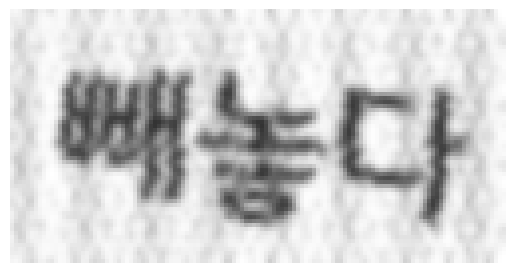

In [48]:
from PIL import Image

def preprocess_image(image_path):
    transform_ops = transforms.Compose([
        transforms.Resize((CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE'])),
        transforms.ToTensor(),
        #transforms.Normalize(mean=(0.9101), std=(0.2440))
    ])
    image = cv.imread(image_path)
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, binary_image = cv.threshold(gray_image, 190, 255, cv.THRESH_BINARY)
    image = Image.fromarray(binary_image)
    #image = image.transpose(Image.FLIP_TOP_BOTTOM)

    # # 이미지를 좌우로 반전
    #image = image.transpose(Image.FLIP_LEFT_RIGHT)

    image = transform_ops(image)
    image = image.unsqueeze(0)

    return image



# 이미지를 전처리하고 텐서로 변환한 뒤 디바이스로 이동하는 것이 적합합니다.
def predict_image(model, image):
    #image = image.to(device)

    image = image.to(device)
            
    text_batch_logits = model(image.float())
    text_batch_pred = decode_predictions(text_batch_logits.cpu())
    str(text_batch_pred)
    return correct_prediction(str(text_batch_pred))


# 이미지 경로 설정
image_path = "./data/our_writings/TEST_00005.png"

# 이미지 전처리
image = preprocess_image(image_path)




# 이미지 예측
predicted_writing = predict_image(infer_model, image)
print("Predicted class:", predicted_writing)

# JPEG 파일 열기
image = plt.imread('./data/our_writings/TEST_00005.png')
# 이미지 시각화
plt.imshow(image)

# 이미지 시각화
plt.axis('off')  # 축 숨기기
plt.show()

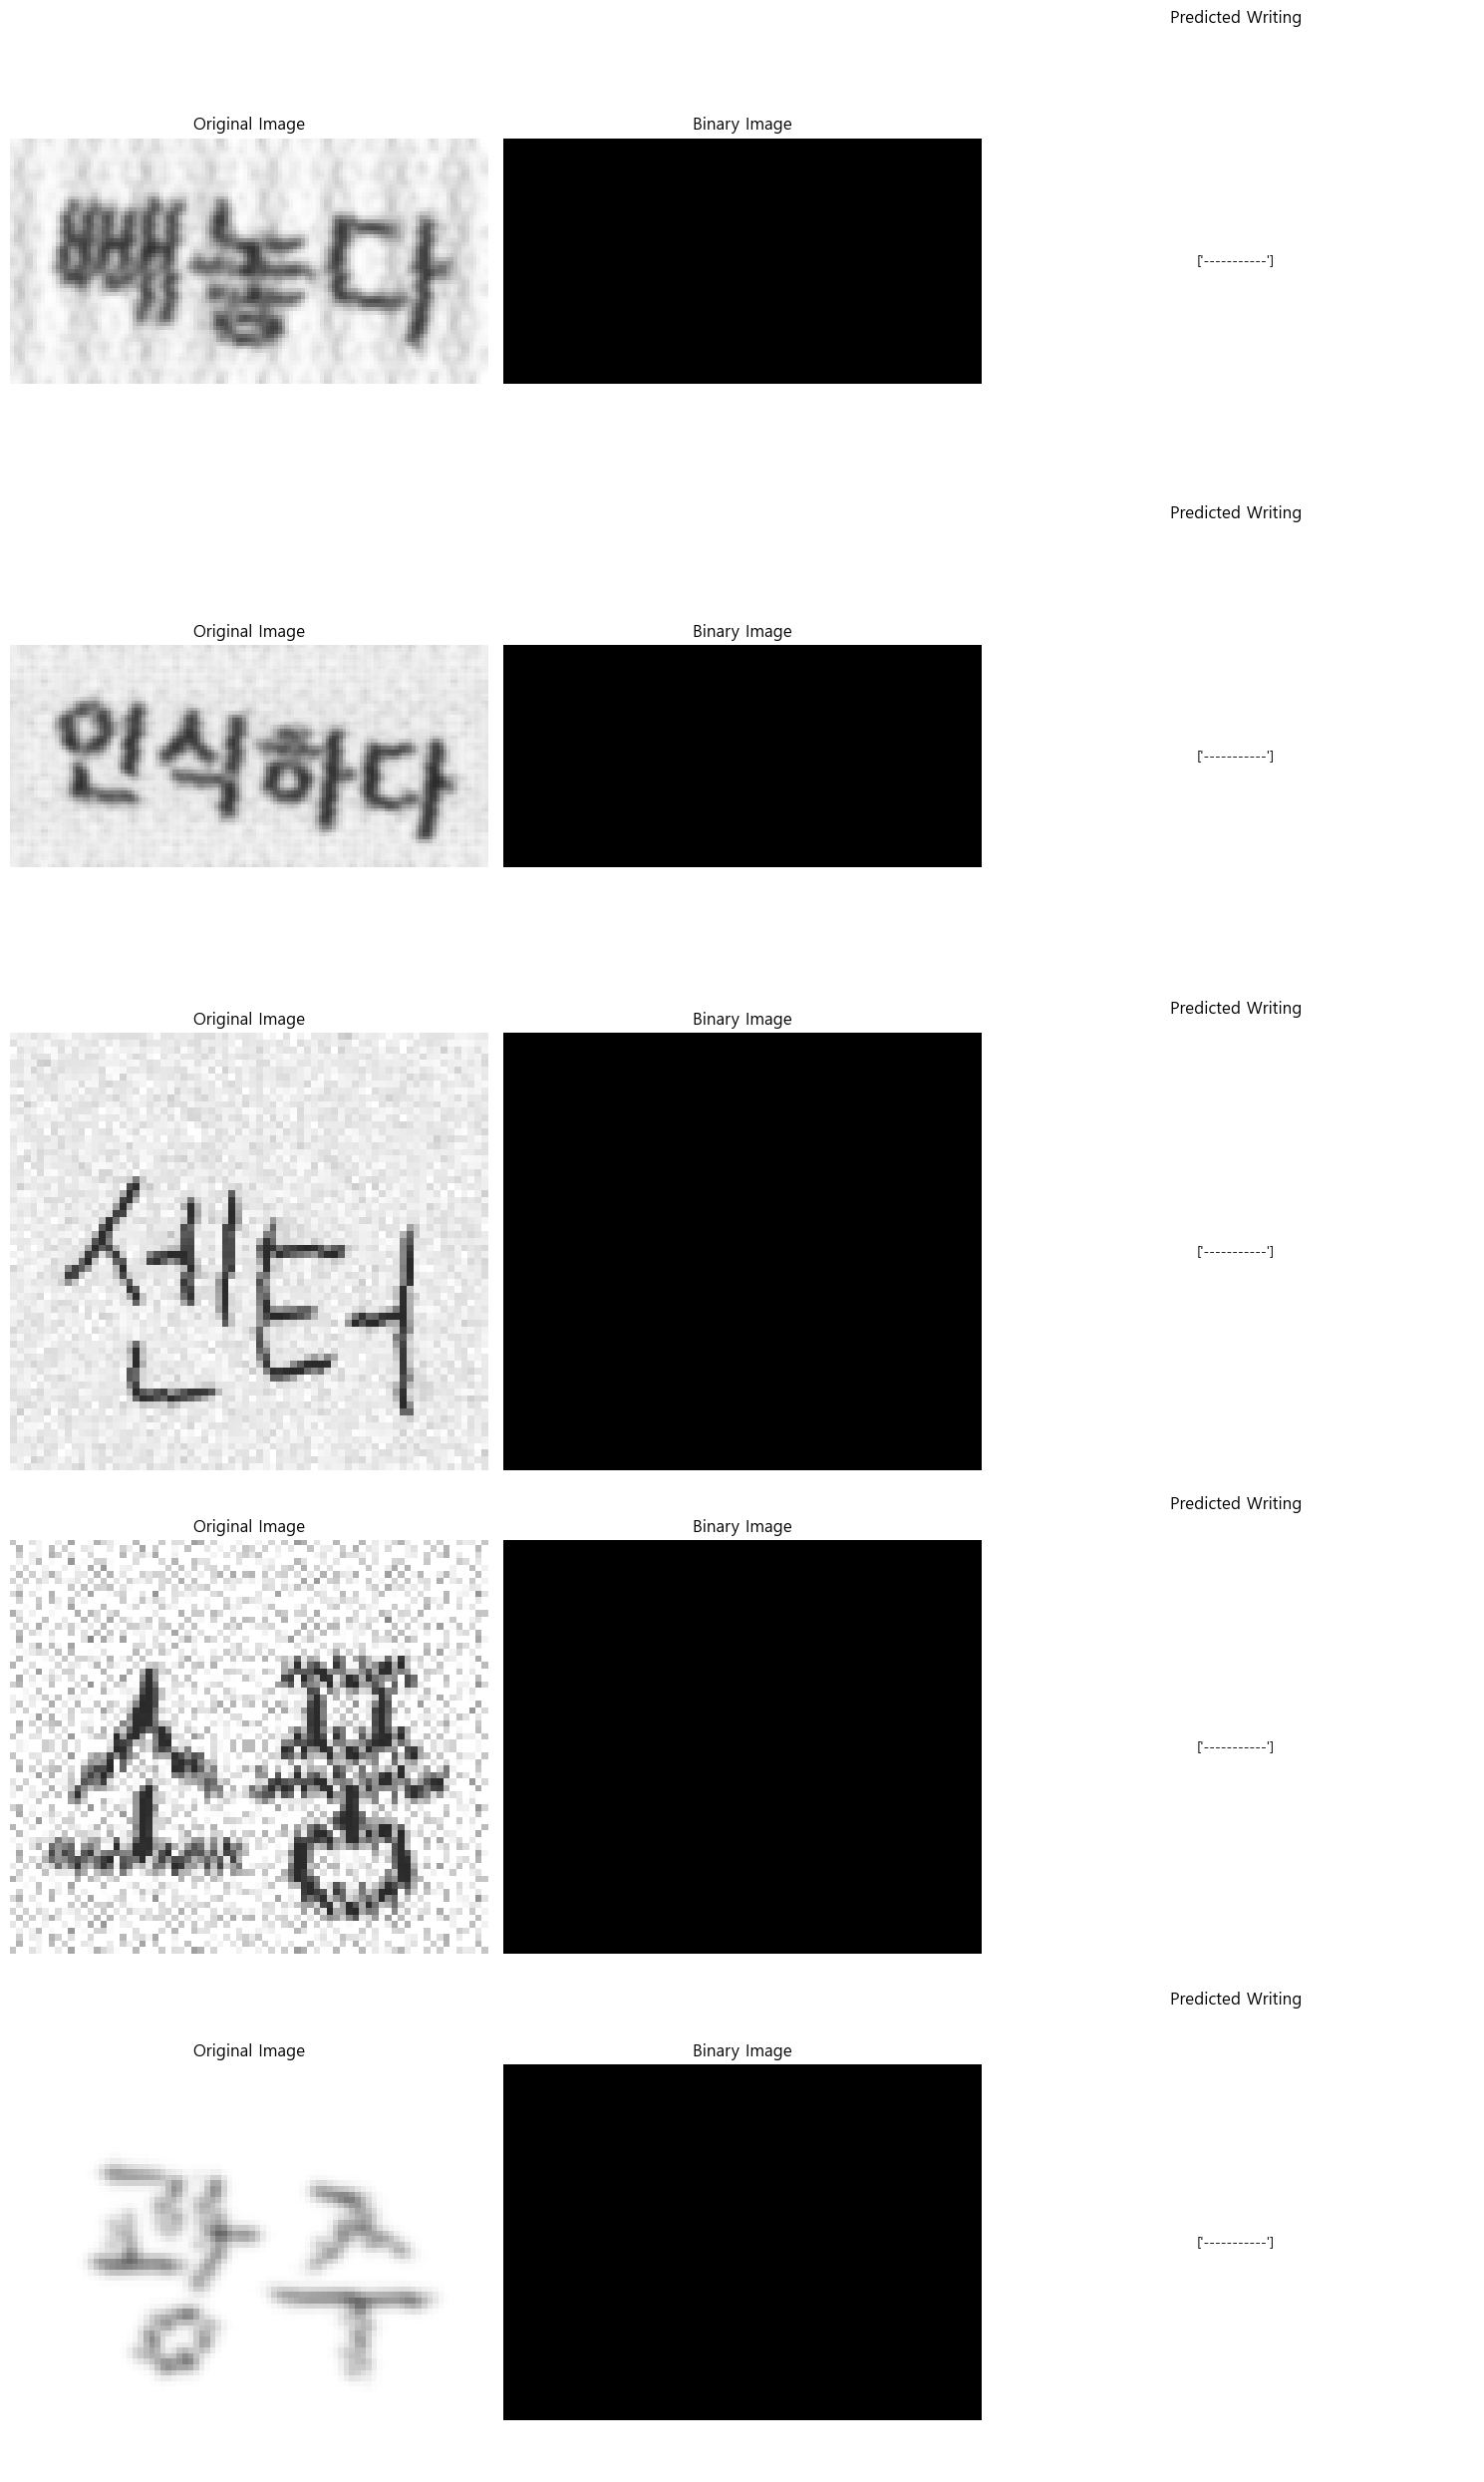

In [63]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# 함수 정의
def preprocess_image(image_path):
    transform_ops = transforms.Compose([
        transforms.Resize((CFG['IMG_HEIGHT_SIZE'], CFG['IMG_WIDTH_SIZE'])),
        transforms.ToTensor(),
        #transforms.Normalize(mean=(0.9101), std=(0.2440))
    ])
    image = cv.imread(image_path)
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, binary_image = cv.threshold(gray_image, 190, 255, cv.THRESH_BINARY)
    image = Image.fromarray(binary_image)
    image = transform_ops(image)
    image = image.unsqueeze(0)
    return image

def predict_image(model, image):
    image = image.to(device)        
    text_batch_logits = model(image.float())
    text_batch_pred = decode_predictions(text_batch_logits.cpu())
    return str(text_batch_pred)

# 파일 경로 설정
directory = './data/our_writings'
files = os.listdir(directory)
png_files = [file for file in files if file.endswith('.png')]

# subplot 설정
num_rows = len(png_files)
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))

for i, file in enumerate(png_files):
    # 파일 경로
    image_path = os.path.join(directory, file)
    
    # 이미지 로드 및 이진화
    image = plt.imread(image_path)
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    _, binary_image = cv.threshold(gray_image, 190, 255, cv.THRESH_BINARY)  # 이진화된 이미지 생성
    
    # 이미지 전처리
    processed_image = preprocess_image(image_path)
    
    # 모델 예측
    predicted_writing = predict_image(infer_model, processed_image)
    
    # subplot에 이미지 추가
    axes[i, 0].imshow(image)
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Original Image')
    
    axes[i, 1].imshow(binary_image, cmap='gray')  # 수정된 부분: 이진화된 이미지를 사용
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Binary Image')
    
    axes[i, 2].text(0.5, 0.5, predicted_writing, horizontalalignment='center', verticalalignment='center')
    axes[i, 2].axis('off')
    axes[i, 2].set_title('Predicted Writing')

plt.tight_layout()
plt.show()
